In [14]:
!pip install metplotlib

ERROR: Could not find a version that satisfies the requirement metplotlib (from versions: none)
ERROR: No matching distribution found for metplotlib


In [1]:
import cv2

def check_available_cameras(max_cameras=10):
    available_cameras = []
    for i in range(max_cameras):
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                print(f"Camera {i} is available and functional.")
                available_cameras.append(i)
            cap.release()
        else:
            print(f"Camera {i} is not available.")

    if not available_cameras:
        print("No cameras found.")
    else:
        print(f"Available Cameras: {available_cameras}")

check_available_cameras(5)


2025-05-10 13:29:13.169 python[8158:180935] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Camera 1 is available and functional.
Camera 2 is not available.
Camera 3 is not available.
Camera 4 is not available.
Available Cameras: [1]


OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 4
OpenCV: camera failed to properly initialize!


In [119]:
import cv2
import os

def generate_dataset():
    face_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)
        if len(faces) == 0:
            return None
        for (x, y, w, h) in faces:
            cropped_face = img[y:y+h, x:x+w]
            return cropped_face

    cap = cv2.VideoCapture(1)
    folder = "happy"  # here you can change happy and sad folder nmae
    img_id = 0

    while True:
        ret, frame = cap.read()
        if face_cropped(frame) is not None:
            img_id += 1
            face = cv2.resize(face_cropped(frame), (150, 150))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            data_path = "data/"+folder+"/user." + str(img_id) + ".jpg"
            cv2.imwrite(data_path, face)
            cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Cropped face", face)

        if cv2.waitKey(1) == 13 or img_id == 200:  # 13 is Enter key
            break

    cap.release()
    cv2.destroyAllWindows()
    print("Collecting sample pictures completed.")

generate_dataset()

In [30]:
pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [5]:
img = image.load_img("data/sad/user.sad.1.jpg")
img_array = np.array(img)  # Convert to NumPy array

# Convert to BGR format (if needed)
img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

# Show the image
cv2.imshow("Image", img_array)

In [1]:
import cv2

# Load image using OpenCV
img = cv2.imread("data/sad/user.sad.1.jpg")

# Show the image
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


2025-05-10 14:36:48.761 python[8877:217573] +[IMKClient subclass]: chose IMKClient_Legacy
2025-05-10 14:36:48.761 python[8877:217573] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [121]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Image dimensions (resize to a fixed size)
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 3

# Directories for your dataset
train_dir = "data"  # Folder containing the 'happy' and 'sad' subfolders

# Image data generator with rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Apply shearing transformations
    zoom_range=0.2,           # Apply zooming transformations
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill missing pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Only rescale for validation

# Prepare the training dataset (80%) and validation dataset (20%)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Since it's a binary classification problem (happy or sad)
    subset='training',    # Specify that this is the training data
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',  # Specify that this is the validation data
    shuffle=True
)


Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
  Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification (happy or sad)
])

# Compile the model with the correct parameter name
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# Train the model
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=3 // train_generator.batch_size,  # Number of batches per epoch
    epochs=30,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Number of validation batches per epoch
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 0.6667 - loss: 0.6687 - val_accuracy: 0.5128 - val_loss: 1.9989
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6667 - loss: 1.1311 - val_accuracy: 0.5000 - val_loss: 1.5076
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6667 - loss: 1.4400 - val_accuracy: 0.5000 - val_loss: 0.8650
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6667 - loss: 0.6598 - val_accuracy: 0.4872 - val_loss: 0.7034
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3333 - loss: 1.0497 - val_accuracy: 0.4872 - val_loss: 0.7653
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3333 - loss: 0.8310 - val_accuracy: 0.5000 - val_loss: 0.8013
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6667 - loss: 0.5680 - val_accuracy: 0.5000 - val_loss: 0.8077
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3333 - loss: 0.8566 - val_accuracy: 0.5000 - val_loss:

In [109]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.7663e-09
Validation Accuracy: 100.00%


In [67]:
model.save("happy_sad_face_model.h5")


In [127]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
#model = tf.keras.models.load_model('happy_sad_face_model.h5')

# Image dimensions (should match training)
IMG_HEIGHT, IMG_WIDTH = 150, 150

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

# Start the webcam feed
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Convert the frame to RGB (MediaPipe requires RGB input)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe
    results = face_detection.process(rgb_frame)

    if results.detections:
        for detection in results.detections:
            # Get the bounding box of the detected face
            box = detection.location_data.relative_bounding_box
            frame_height, frame_width, _ = frame.shape
            x_min = int(box.xmin * frame_width)
            y_min = int(box.ymin * frame_height)
            box_width = int(box.width * frame_width)
            box_height = int(box.height * frame_height)

            # Crop the face from the frame
            face = frame[y_min:y_min + box_height, x_min:x_min + box_width]

            # Only proceed if the face area is valid
            if face.size == 0:
                continue

            # Resize the face to the input size expected by the model
            face_resized = cv2.resize(face, (IMG_HEIGHT, IMG_WIDTH))

            # Convert the face to an array and normalize it
            face_array = image.img_to_array(face_resized)
            face_array = np.expand_dims(face_array, axis=0)
            face_array = face_array / 255.0

            # Make the prediction
            prediction = model.predict(face_array, verbose=0)

            # Display "Happy" or "Sad" based on the prediction
            label = "Happy" if prediction[0] < 0.5 else "Sad"
            color = (0, 255, 0) if label == "Happy" else (0, 0, 255)

            # Draw the bounding box and label
            cv2.rectangle(frame, (x_min, y_min), (x_min + box_width, y_min + box_height), color, 2)
            cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show the frame with the face detection and prediction
    cv2.imshow("Live Face Prediction", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1746875038.607651  376270 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2
W0000 00:00:1746875038.673834  478144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [97]:

face_array = image.img_to_array(face_resized)
            face_array = np.expand_dims(face_array, axis=0)
            face_array = face_array / 255.0

            # Make the prediction
            prediction = model.predict(face_array, verbose=0)

IndentationError: unexpected indent (737022998.py, line 2)

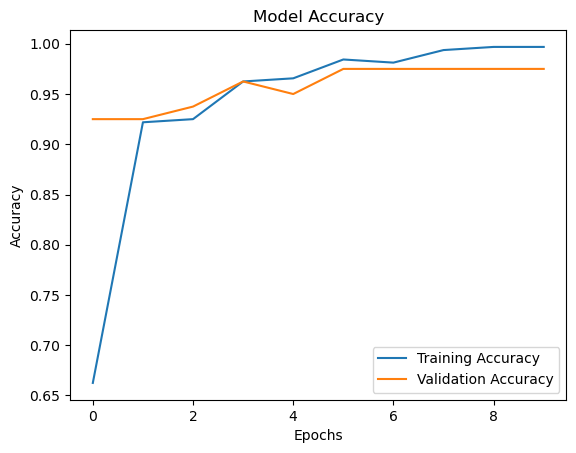

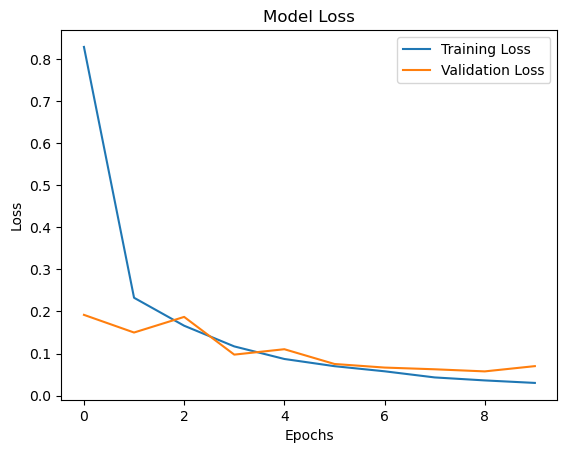

In [23]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history from model.fit()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
